https://github.com/dsgiitr/d2l-pytorch/blob/master/Ch10_Recurrent_Neural_Networks/Sequence_to_Sequence.ipynb


In [1]:
from d2l import torch as d2l
import torch
from torch import nn

In [2]:
class Seq2SeqAttentionDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention_cell = d2l.MLPAttention(num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size+num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_len, *args):
        outputs, hidden_state = enc_outputs
        # Transpose outputs to (batch_size, seq_len, num_hiddens)
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_len)

    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_len = state
        X = self.embedding(X).permute(1, 0, 2)
        outputs = []
        for x in X:
            # query shape: (batch_size, 1, num_hiddens)
            query = torch.unsqueeze(hidden_state[0][-1], dim=1)
            # context has same shape as query
            context = self.attention_cell(
                query, enc_outputs, enc_outputs, enc_valid_len)
            # Concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # Reshape x to (1, batch_size, embed_size + num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_len]

In [3]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8,
                             num_hiddens=16, num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8,
                                  num_hiddens=16, num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
state = decoder.init_state(encoder(X), None)
out, state = decoder(X, state)
out.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([2, 4, 16]))

loss 0.025, 2612.7 tokens/sec on cpu


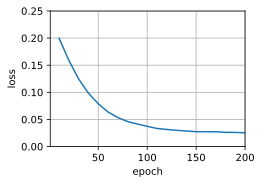

In [4]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.0
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()

src_vocab, tgt_vocab, train_iter = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
d2l.train_s2s_ch9(model, train_iter, lr, num_epochs, device)

In [5]:
for sentence in ['Go .', 'Wow !', "I'm OK .", 'I won !']:
    print(sentence + ' => ' + d2l.predict_s2s_ch9(
        model, sentence, src_vocab, tgt_vocab, num_steps, device))

Go . => va !
Wow ! => <unk> !
I'm OK . => je vais bien .
I won ! => je l'ai emporté !
